### Importing the Libraries

In [8]:
import numpy as np
import pandas as pd
import string
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets
from ipywidgets import interact

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

### Reading the Data

In [9]:
# reading the Dataset
data = pd.read_csv('drugs2.csv')

# lets print the shape of the dataset
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (53766, 7)


In [10]:
# lets check the head of the dataset
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [11]:
# lets Explore Some of the Important Column in the dataset

print("Number of Unique Drugs present in the Dataset :", data['drugName'].nunique())
print("Number of Unique Medical Conditions present in the Dataset :", data['condition'].nunique())

print("\nThe Time Period of Collecting the Data")
print("Starting Date :", data['date'].min())
print("Ending Date :", data['date'].max())

Number of Unique Drugs present in the Dataset : 2637
Number of Unique Medical Conditions present in the Dataset : 708

The Time Period of Collecting the Data
Starting Date : 1-Apr-08
Ending Date : 9-Sep-17


### Summarizing the Dataset

In [12]:
# lets summarize the Dataset
data[['rating','usefulCount']].describe()

,rating,usefulCount
count,53766.000000,53766.000000
mean,6.976900,27.989752
std,3.285207,36.172833
min,1.000000,0.000000
25%,4.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,949.000000


In [13]:
# lets check the Number and Name of the Drugs with 0 Useful Count in Details
print("Analysis on Useless Drugs")
print("----------------------------")
print("The Number of Drugs with No Useful Count :", data[data['usefulCount'] == 0].count()[0])

# Lets Check the Number of Drugs with No Usesful Count with Review Greater than or Equal to 8
print("Number of Good Drugs with Lesser Useful Count :", data[(data['usefulCount'] == 0) &
                                                data['rating'] >= 8].count()[0])

# Lets Check the Average Rating of the Drugs with No Useful Count
print("Average Rating of Drugs with No Useful Count : {0:.2f}".format(data[data['usefulCount'] == 0]['rating'].mean()))

print("\nAnalysis on Useful Drugs")
print("----------------------------")
print("The Number of Drugs with Greater than 1000 Useful Counts :", data[data['usefulCount'] > 1000].count()[0])
print("Average Rating of Drugs with 1000+ Useful Counts :", data[data['usefulCount'] > 1000]['rating'].mean())
print("\nName and Condition of these Drugs: \n\n", 
    data[data['usefulCount'] > 1000][['drugName','condition']].reset_index(drop = True))

Analysis on Useless Drugs
----------------------------
The Number of Drugs with No Useful Count : 2084
Number of Good Drugs with Lesser Useful Count : 0
Average Rating of Drugs with No Useful Count : 5.87

Analysis on Useful Drugs
----------------------------
The Number of Drugs with Greater than 1000 Useful Counts : 0
Average Rating of Drugs with 1000+ Useful Counts : nan

Name and Condition of these Drugs: 

 Empty DataFrame
Columns: [drugName, condition]
Index: []


In [14]:
# lets summarize Categorical data also
data[['drugName','condition','review']].describe(include = 'object')

,drugName,condition,review
count,53766,53471,53766
unique,2637,708,48280
top,Levonorgestrel,Birth Control,"""Good."""
freq,1273,9648,8


In [15]:
# lets check for Missing Values
data.isnull().sum()

uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [16]:
# as we know that condition is an Important Column, so we will delete all the records where Condition is Missing
data = data.dropna()

# lets check the Missing values now
data.isnull().sum().sum()

0

### Unveiling Hidden Patterns from the Data

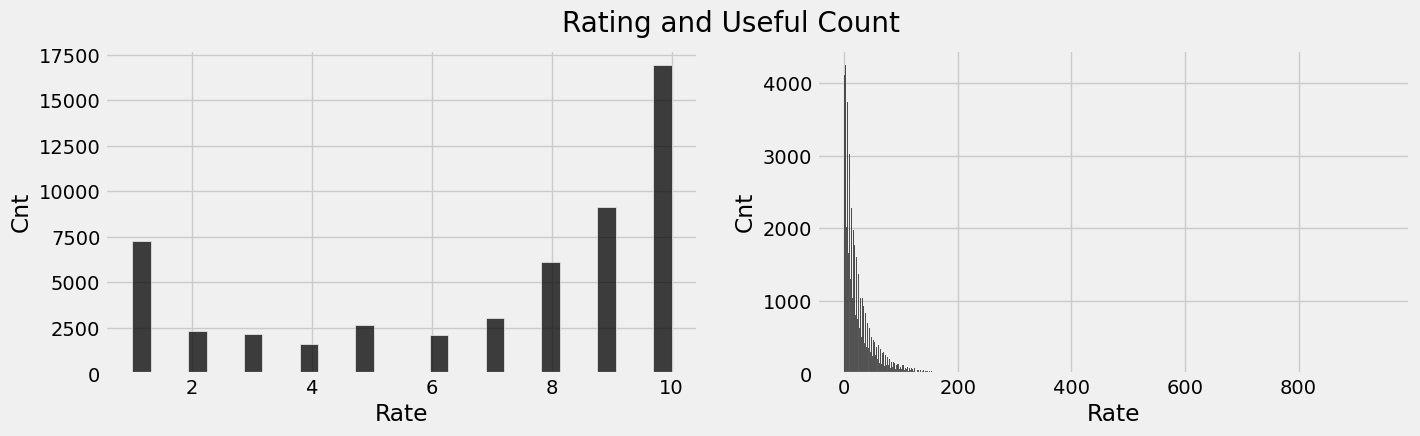

In [17]:
# lets check the Distribution of Rating and Useful Count

plt.rcParams['figure.figsize'] = (15, 4)

plt.subplot(1, 2, 1)
ax=sns.histplot(data['rating'],color="Black")
ax.set(xlabel="Rate",ylabel="Cnt")
plt.subplot(1, 2, 2)
bx=sns.histplot(data['usefulCount'],color="Black")
bx.set(xlabel="Rate",ylabel="Cnt")
plt.suptitle('Rating and Useful Count \n ', fontsize = 20)
plt.show()

In [18]:
# Checking whether Length of Review has any Impact on Ratings of the Drugs

# for that we need to create a new column to calculate length of the reviews
data['len']  = data['review'].apply(len)

In [19]:
# lets check the Impact of Length of Reviews on Ratings
data[['rating','len']].groupby(['rating']).agg(['min','mean','max'])

len                  
       min        mean   max
rating                      
1        5  427.267447  3103
2       14  458.453959  2376
3        8  449.259445  2142
4        5  468.612667  1558
5       10  480.199926  2010
6        4  471.655566  2202
7        6  482.972358  1266
8        6  479.849134  1603
9        3  476.221930  2733
10       6  445.299994  6192

### Cleaning the Reviews

In [20]:
# as it is clear that the reviews have so many unnecassry things such as Stopwords, Punctuations, numbers etc

# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

data['review'] = data['review'].apply(punctuation_removal)
print(data['review'])


0        I039ve tried a few antidepressants over the ye...
1        My son has Crohn039s disease and has done very...
2                              Quick reduction of symptoms
3        Contrave combines drugs that were used for alc...
4        I have been on this birth control for one cycl...
                               ...                        
53761    I have taken Tamoxifen for 5 years Side effect...
53762    I039ve been taking Lexapro escitaploprgram sin...
53763    I039m married 34 years old and I have no kids ...
53764    I was prescribed Nucynta for severe neckshould...
53765                                             It works
Name: review, Length: 53471, dtype: object


In [21]:
# Now lets Remove the Stopwords also
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download("stopwords")

stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

data['review'] = data['review'].apply(stopwords_removal)

In [22]:
# lets remove the Numbers also

import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

data['review'] = data['review'].apply(drop_numbers)

In [23]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.histplot(data = df_frequency, x = "Word", y = "Frequency", color = 'black')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    #df_frequency.plot(kind='pie',x="Word",y = "Frequency",autopct='%1.0f%%', shadow=False)
    plt.show()

In [24]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,len
0,163740,Mirtazapine,Depression,tried antidepressants years citalopram fluoxet...,10,28-Feb-12,22,439
1,206473,Mesalamine,"Crohn's Disease, Maintenance",son disease done well asacol complaints shows ...,8,17-May-09,17,268
2,159672,Bactrim,Urinary Tract Infection,quick reduction symptoms,9,29-Sep-17,3,29
3,39293,Contrave,Weight Loss,contrave combines drugs used alcohol smoking o...,9,5-Mar-17,35,782
4,97768,Cyclafem 1 / 35,Birth Control,birth control one cycle reading reviews type s...,9,22-Oct-15,4,762


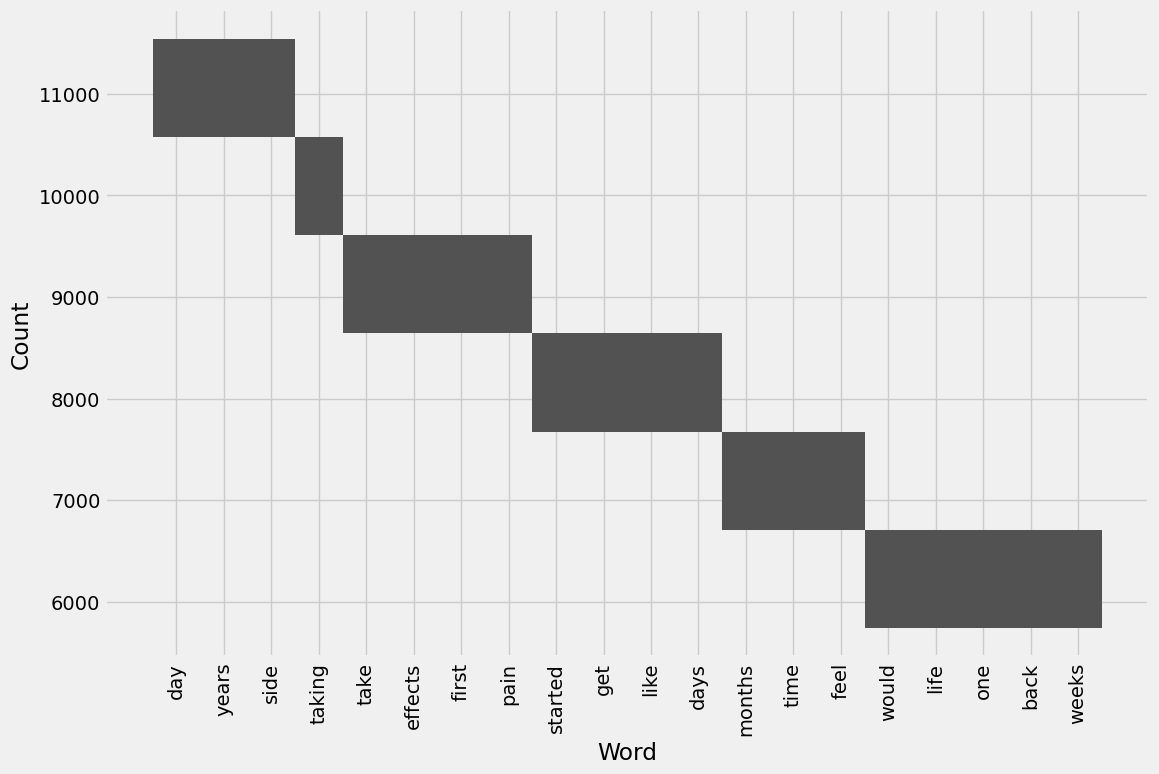

In [25]:
counter(data[data["rating"] >= 8], "review", 20)

In [26]:
# Split the data4
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['review'], data.rating, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 67.1%


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(data['review'], data.rating, test_size=0.2, random_state=42)


pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(n_estimators=100))])

model = pipe.fit(X_train, y_train)# create a gradient boosting classifier

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,X_test,y_train,y_test = train_test_split(data['review'], data.rating, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SVC(kernel='rbf', C=1))])


model = pipe.fit(X_train, y_train)# create a gradient boosting classifier

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

### Calculating the Sentiment from Reviews

In [27]:
# for using Sentiment Analyzer we will have to dowload the Vader Lexicon from NLTK

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tirth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
# lets calculate the Sentiment from Reviews

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

train_sentiments = []

for i in data['review']:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
train_sentiments = np.asarray(train_sentiments)
data['sentiment'] = pd.Series(data=train_sentiments)

In [30]:
# lets check Impact of Sentiment on Reviews
data[['rating','sentiment']].groupby(['rating']).agg(['min','mean','max'])

sentiment                  
             min      mean     max
rating                            
1        -0.9938 -0.011343  0.9935
2        -0.9946 -0.000385  0.9833
3        -0.9919 -0.005612  0.9864
4        -0.9914 -0.029316  0.9850
5        -0.9876  0.014860  0.9814
6        -0.9894  0.008093  0.9828
7        -0.9916 -0.012391  0.9884
8        -0.9936  0.009604  0.9935
9        -0.9982  0.012665  0.9882
10       -0.9949  0.006805  0.9911

### Calculating Effectiveness and Usefulness of Drugs

In [31]:
# Lets Calculate an Effective Rating


min_rating = data['rating'].min()
max_rating = data['rating'].max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating/(max_rating -1)
    rating *= 5
    rating = int(round(rating,0))
    
    if(int(rating) == 0 or int(rating)==1 or int(rating)==2):
        return 0
    else:
        return 1
    
data['eff_score'] = data['rating'].apply(scale_rating)

In [32]:
# lets also calculate Usefulness Score

data['usefulness'] = data['rating']*data['usefulCount']*data['eff_score']

# lets check the Top 10 Most Useful Drugs with their Respective Conditions
data[['drugName','condition','usefulness']][data['usefulness'] > 
                            data['usefulness'].mean()].sort_values(by = 'usefulness', 
                                        ascending = False).head(10).reset_index(drop = True)

,drugName,condition,usefulness
0,Sertraline,Depression,8541
1,Etonogestrel,Birth Control,7300
2,Sertraline,Depression,6800
3,Oxycodone,Pain,6255
4,OxyContin,Pain,6255
5,Cymbalta,Depression,6210
6,Sertraline,Depression,5796
7,Buspirone,Anxiety,5265
8,Citalopram,Depression,5031
9,Prozac,Anxiety and Stress,4860


### Analyzing the Medical Condtitions

In [33]:
# lets calculate the Number of Useless and Useful Drugs for Each Condition

#@interact
#def check(condition = list(data['condition'].value_counts().index)):
 #   return data[data['condition'] == condition]['eff_score'].value_counts()

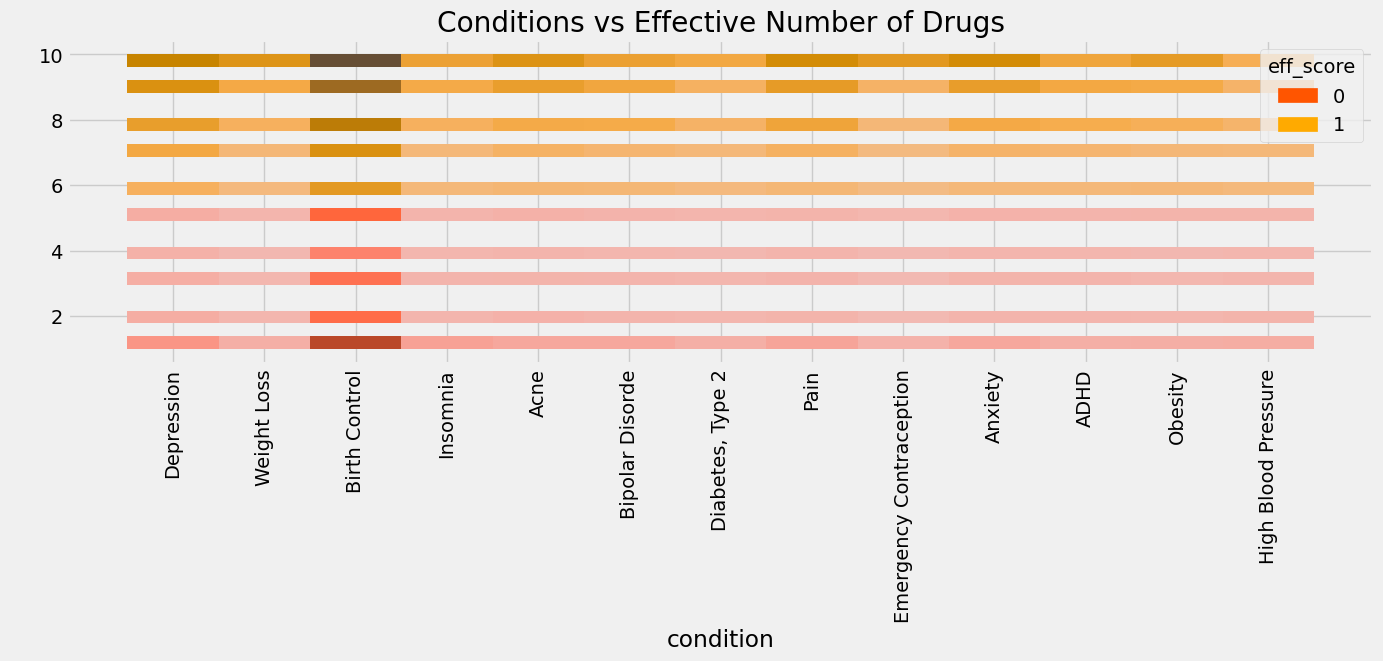

In [34]:
# lets check this in Graph, 

popular_conditions = ('Birth Control','Depression','Pain','Anxiety','Acne','Bipolar Disorde','Insomnia','Weight Loss',
                      'Obesity','ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure','Migrane')
conditions = data.loc[data['condition'].isin(popular_conditions)]

sns.histplot(x = conditions['condition'], y = conditions['rating'], hue = data['eff_score'], 
     palette = 'autumn')
plt.title('Conditions vs Effective Number of Drugs')
plt.xticks(rotation = 90)
plt.ylabel(' ')
plt.show()

In [35]:
# lets check the Most Common Conditions

print("Number of Unique Conditions :", data['condition'].nunique())
data['condition'].value_counts().head(10)

Number of Unique Conditions : 708


Birth Control      9648
Depression         3095
Pain               2100
Anxiety            1908
Acne               1847
Bipolar Disorde    1380
Weight Loss        1248
Insomnia           1231
Obesity            1189
ADHD               1126
Name: condition, dtype: int64

In [36]:
# lets check Drugs, which were useful to Highest Number of Poeple
data[['drugName','usefulCount']][data['usefulCount'] >
                    data['usefulCount'].mean()].sort_values(by = 'usefulCount',
                                        ascending = False).head(10).reset_index(drop = True)

,drugName,usefulCount
0,Sertraline,949
1,Etonogestrel,730
2,OxyContin,695
3,Oxycodone,695
4,Sertraline,680
5,Sertraline,644
6,Cymbalta,621
7,Buspirone,585
8,Citalopram,559
9,Vilazodone,513


### Finding Most Useful and Useless Drugs for each Condition

In [37]:
# lets remove all the Duplicates from the Dataset
data = data.drop_duplicates()

In [38]:
import ipywidgets as widgets
from IPython.display import display

# Create a text box for user input
search_box = widgets.Text(
    value='',
    placeholder='Enter a condition',
    description='Search:',
    disabled=False
)

# Define the function to display the top 5 and bottom 5 drugs
def high_low_rate(condition):
    if condition in data['condition'].values:
        x=data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',ascending = False).head().reset_index(drop = True)
        plt.bar(x['drugName'],x['usefulness'])
        plt.title("Top Drugs")
        plt.xlabel("Drugs")
        plt.ylabel("Usefulness")
        plt.show()
        #print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',ascending = False).head().reset_index(drop = True))
        print("\n\n")
        y=data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',ascending = True).head().reset_index(drop = True)
        plt.bar(y['drugName'],y['usefulness'])
        plt.title("Bottom Drugs")
        plt.xlabel("Drugs")
        plt.ylabel("Usefulness")
        plt.show()
        #print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',ascending = True).head().reset_index(drop = True))
    else:
        print("Condition not found in dataset")

# Display the search box and call the function on user input
display(search_box)
widgets.interact(high_low_rate, condition=search_box);

Text(value='', description='Search:', placeholder='Enter a condition')

interactive(children=(Text(value='', description='Search:', placeholder='Enter a condition'), Output()), _dom_…